In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import math
import matplotlib.pyplot as plt

In [2]:
# 1. Finite Difference Method

# a + b. Finite difference scheme
def assemble_system(N, kappa, alpha, beta, f_func):
    h = 1.0 / N
    xi = np.linspace(h, 1 - h, N - 1)

    main = (2.0 / h**2 + kappa) * np.ones(N - 1)
    off  = (-1.0 / h**2) * np.ones(N - 2)
    A = sp.diags([off, main, off], offsets=[-1, 0, 1], format="csr")

    b = f_func(xi).astype(float)
    b[0]  += alpha / h**2
    b[-1] += beta  / h**2
    return A, b, xi, h

In [3]:
# 2. Multigrid Method
# 2.1. Prolongation and Restriction

# c + d + e. Prolongation and Restriction Operators
def prolongation(Nf):
    Nc = Nf // 2
    n_f_nodes = Nf + 1
    n_c_nodes = Nc + 1

    rows, cols, vals = [], [], []
    for i in range(Nf):
        if i % 2 == 0:
            k = i // 2
            rows.append(i); cols.append(k); vals.append(1.0)
        else:
            k = i // 2
            rows += [i, i]
            cols += [k, k + 1]
            vals += [0.5, 0.5]

    rows.append(Nf); cols.append(Nc); vals.append(1.0)

    P = sp.coo_matrix((vals, (rows, cols)), shape=(n_f_nodes, n_c_nodes)).tocsr()
    return P, np.array(rows), np.array(cols), np.array(vals)

def restriction(P):
    return 0.5 * P.transpose().tocsr()

In [4]:
N = 10
xc = np.arange(0, N/2 + 1)
xc = xc.reshape(-1, 1)  

P, rows, cols, vals = prolongation(N)
print("Matrix P:\n", P.toarray())


Matrix P:
 [[1.  0.  0.  0.  0.  0. ]
 [0.5 0.5 0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0. ]
 [0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.5 0.5]
 [0.  0.  0.  0.  0.  1. ]]


In [5]:
# 2.2. Implementation

# Preparation
def build_levels(Nf, kappa, alpha, beta, f_func):
    Ns, N = [], int(Nf)
    while (N % 2 == 0) and (N >= 2):
        Ns.append(N)
        N //= 2
    Ns = Ns[::-1]
    L = len(Ns) - 1 

    A_list, b_list = [], []
    for Nlev in Ns:
        A, b, _, _ = assemble_system(Nlev, kappa, alpha, beta, f_func)
        A_list.append(A); b_list.append(b)

    P_list, R_list = [], []
    for i in range(L):
        Nfine = Ns[i+1] 
        P_i, _, _, _ = prolongation(Nfine)
        P_list.append(P_i)
        R_list.append(restriction(P_i))

    def _eig_extremes(A):
        n = A.shape[0]
        if n == 1:
            val = float(A[0, 0]) if sp.issparse(A) else float(A[0, 0])
            return val, val
        try:
            lam_max = spla.eigsh(A, k=1, which='LA', return_eigenvectors=False, tol=1e-6)[0]
            lam_min = spla.eigsh(A, k=1, which='SA', return_eigenvectors=False, tol=1e-6)[0]
            return float(lam_max), float(lam_min)
        except Exception:
            evals = np.linalg.eigvalsh(A.toarray())
            return float(evals[-1]), float(evals[0])

    lam_max_list, lam_min_list, gamma_list = [], [], []
    for A, Nlev in zip(A_list, Ns):
        lam_max, lam_min = _eig_extremes(A)
        lam_max_list.append(lam_max)
        lam_min_list.append(lam_min)
        gamma_list.append(2.0 / (lam_max + lam_min))
    
    if len(P_list) != L:
        print(f"[CHECK] WARNING: have {len(P_list)} prolongations but expected {L}.")
    else:
        print(f"[CHECK] P count OK: {len(P_list)} = k.")

    return {
        "Ns": Ns, 
        "A_list": A_list,
        "b_list": b_list,
        "P_list": P_list,
        "R_list": R_list,
        "lam_max_list": lam_max_list,
        "lam_min_list": lam_min_list,
        "gamma_list": gamma_list,
        "alpha": alpha, "beta": beta,
        "k": L
    }


In [6]:
levels = build_levels(
    Nf=2**4, kappa=1, alpha=0, beta=0,
    f_func=lambda x: np.ones_like(x)
)


[CHECK] P count OK: 3 = k.


In [7]:
# Multigrid Code
# f + g + h. Multigrid Code Update
def smooth_richardson(A, b, x, gamma, m):
    for _ in range(m):
        r = b - A @ x
        x = x + gamma * r
    return x

def _restrict_interior(r_f, R_f):
    r_full = np.empty(r_f.size + 2)
    r_full[0] = 0.0
    r_full[1:-1] = r_f
    r_full[-1] = 0.0
    rc_full = R_f @ r_full
    return rc_full[1:-1]

def _prolong_interior(e_c, P_f):
    ec_full = np.empty(e_c.size + 2)
    ec_full[0] = 0.0
    ec_full[1:-1] = e_c
    ec_full[-1] = 0.0
    ef_full = P_f @ ec_full
    return ef_full[1:-1]

def MG(k, levels, x0, m=1, cycle='V', rhs=None):
    A_list = levels["A_list"];  b_list = levels["b_list"]
    P_list = levels["P_list"];  R_list = levels["R_list"]
    gamma  = levels["gamma_list"][k]

    A = A_list[k]
    b = b_list[k] if rhs is None else rhs

    if k == 0:
        return spla.spsolve(A, b)

    x = smooth_richardson(A, b, x0.copy(), gamma, m)
    r_f = b - A @ x
    r_c = _restrict_interior(r_f, R_list[k-1])
    e_c = MG(k-1, levels, np.zeros_like(r_c), m=m, cycle=cycle, rhs=r_c)

    if cycle == 'W':
        A_c = A_list[k-1]
        r_c2 = r_c - A_c @ e_c
        e_c += MG(k-1, levels, np.zeros_like(r_c), m=m, cycle=cycle, rhs=r_c2)

    e_f = _prolong_interior(e_c, P_list[k-1])
    x = x + e_f

    x = smooth_richardson(A, b, x, gamma, m)
    return x

def mg_solve(levels, m=1, cycle='V', tol=1e-6, max_cycles=20):
    kf = levels["k"]
    A  = levels["A_list"][kf]
    b  = levels["b_list"][kf]
    x  = np.zeros_like(b)
    hist = []

    nb = np.linalg.norm(b) + 1e-15
    for _ in range(max_cycles):
        r = b - A @ x
        rel = np.linalg.norm(r) / nb
        hist.append(rel)
        if rel <= tol:
            break
        x = MG(kf, levels, x, m=m, cycle=cycle, rhs=b)
    return x, hist


In [8]:
print("  N        h            λ_max          λ_min            γ       h^2*λ_max    γ/h^2")

for N, lamM, lamm, g in zip(levels["Ns"], 
                            levels["lam_max_list"], 
                            levels["lam_min_list"], 
                            levels["gamma_list"]):
    h = 1.0 / N
    print(f"{N:>3}  {h: .5e}  {lamM: .6e}  {lamm: .6e}  {g: .6e}   {(h*h*lamM): .4f}    {(g/(h*h)): .4f}")

  N        h            λ_max          λ_min            γ       h^2*λ_max    γ/h^2
  2   5.00000e-01   9.000000e+00   9.000000e+00   1.111111e-01    2.2500     0.4444
  4   2.50000e-01   5.562742e+01   1.037258e+01   3.030303e-02    3.4767     0.4848
  8   1.25000e-01   2.472566e+02   1.074342e+01   7.751938e-03    3.8634     0.4961
 16   6.25000e-02   1.015162e+03   1.083794e+01   1.949318e-03    3.9655     0.4990


[CHECK] P count OK: 11 = k.
V-cycle: cycles=10, final relres=9.24e-01
W-cycle: cycles=10, final relres=9.24e-01


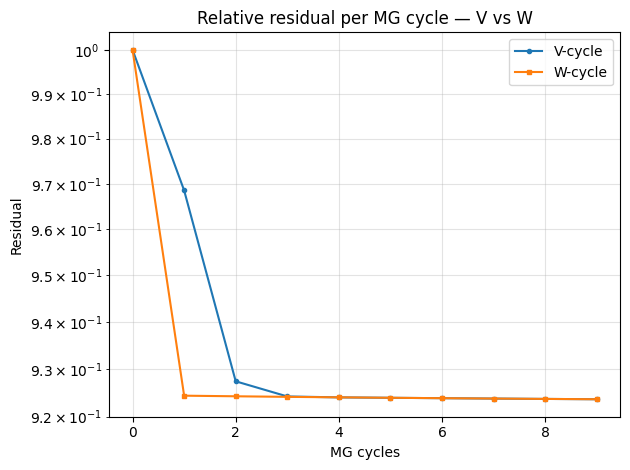

Relative difference V vs W = 2.20e-09

Running 1000 cycles for both V and W
V-cycle: cycles=1000, final relres=9.12e-01
W-cycle: cycles=1000, final relres=9.12e-01
Relative difference V vs W (1000 cycles) = 5.95e-14


In [9]:
# 3. Testing Your Multigrid Code

# i. κ = 1, f = 1, α = 0, β = 0, k = 12, m = 1

Nf = 2**12

def _ncycles_from_hist(hist):
    return int(np.sum(np.array(hist) > 1e-6))

levels_i = build_levels(
    Nf=Nf, kappa=1.0, alpha=0.0, beta=0.0,
    f_func=lambda x: np.ones_like(x)
)

xV_i, histV_i = mg_solve(levels_i, m=1, cycle='V', tol=1e-6, max_cycles=10)
xW_i, histW_i = mg_solve(levels_i, m=1, cycle='W', tol=1e-6, max_cycles=10)

xV_i1000, histV_i1000 = mg_solve(levels_i, m=1, cycle='V', tol=1e-6, max_cycles=1000)
xW_i1000, histW_i1000 = mg_solve(levels_i, m=1, cycle='W', tol=1e-6, max_cycles=1000)

print(f"V-cycle: cycles={_ncycles_from_hist(histV_i)}, final relres={histV_i[-1]:.2e}")
print(f"W-cycle: cycles={_ncycles_from_hist(histW_i)}, final relres={histW_i[-1]:.2e}")

plt.figure()
plt.semilogy(range(len(histV_i)), histV_i, marker='o', ms=3, label='V-cycle')
plt.semilogy(range(len(histW_i)), histW_i, marker='s', ms=3, label='W-cycle')
plt.title("Relative residual per MG cycle — V vs W")
plt.xlabel("MG cycles"); plt.ylabel(r"Residual")
plt.grid(True, which='both', alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()

rel_diff = np.linalg.norm(xV_i - xW_i) / (np.linalg.norm(xV_i) + 1e-15)
rel_diff1000 = np.linalg.norm(xV_i1000 - xW_i1000) / (np.linalg.norm(xV_i1000) + 1e-15)
print(f"Relative difference V vs W = {rel_diff:.2e}")

print("\nRunning 1000 cycles for both V and W")
print(f"V-cycle: cycles={_ncycles_from_hist(histV_i1000)}, final relres={histV_i1000[-1]:.2e}")
print(f"W-cycle: cycles={_ncycles_from_hist(histW_i1000)}, final relres={histW_i1000[-1]:.2e}")
print(f"Relative difference V vs W (1000 cycles) = {rel_diff1000:.2e}")

[CHECK] P count OK: 11 = k.
V-cycle: cycles=5, final relres=7.09e-06
W-cycle: cycles=5, final relres=7.09e-06


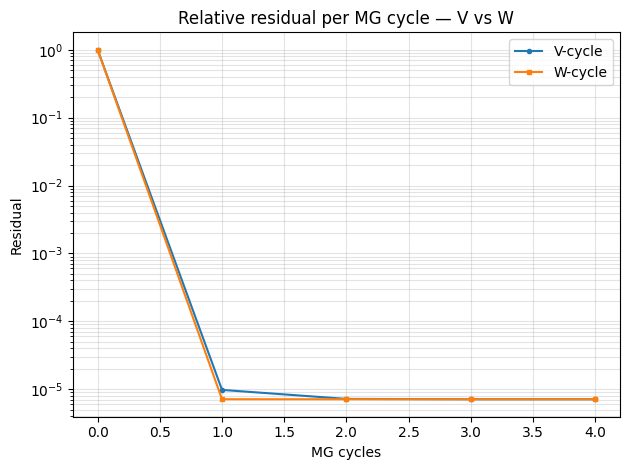

Relative difference V vs W = 1.99e-06

Running 1000 cycles for both V and W
V-cycle: cycles=1000, final relres=6.89e-06
W-cycle: cycles=1000, final relres=6.89e-06
Relative difference V vs W (1000 cycles) = 5.82e-14


In [10]:
# j. κ = 5, f = sin(x), α = 0, β = 0, k = 12, m = 1

levels_j = build_levels(
    Nf=Nf, kappa=5.0, alpha=0.0, beta=1.0,
    f_func=lambda x: np.sin(x)
)

xV_j, histV_j = mg_solve(levels_j, m=1, cycle='V', tol=1e-6, max_cycles=5)
xW_j, histW_j = mg_solve(levels_j, m=1, cycle='W', tol=1e-6, max_cycles=5)

xV_j1000, histV_j1000 = mg_solve(levels_j, m=1, cycle='V', tol=1e-6, max_cycles=1000)
xW_j1000, histW_j1000 = mg_solve(levels_j, m=1, cycle='W', tol=1e-6, max_cycles=1000)

print(f"V-cycle: cycles={_ncycles_from_hist(histV_j)}, final relres={histV_j[-1]:.2e}")
print(f"W-cycle: cycles={_ncycles_from_hist(histW_j)}, final relres={histW_j[-1]:.2e}")

plt.figure()
plt.semilogy(range(len(histV_j)), histV_j, marker='o', ms=3, label='V-cycle')
plt.semilogy(range(len(histW_j)), histW_j, marker='s', ms=3, label='W-cycle')
plt.title("Relative residual per MG cycle — V vs W")
plt.xlabel("MG cycles"); plt.ylabel(r"Residual")
plt.grid(True, which='both', alpha=0.35); plt.legend()
plt.tight_layout(); plt.show()

rel_diff = np.linalg.norm(xV_j - xW_j) / (np.linalg.norm(xV_j) + 1e-15)
rel_diff1000 = np.linalg.norm(xV_j1000 - xW_j1000) / (np.linalg.norm(xV_j1000) + 1e-15)
print(f"Relative difference V vs W = {rel_diff:.2e}")

print("\nRunning 1000 cycles for both V and W")
print(f"V-cycle: cycles={_ncycles_from_hist(histV_j1000)}, final relres={histV_j1000[-1]:.2e}")
print(f"W-cycle: cycles={_ncycles_from_hist(histW_j1000)}, final relres={histW_j1000[-1]:.2e}")
print(f"Relative difference V vs W (1000 cycles) = {rel_diff1000:.2e}")

[CHECK] P count OK: 11 = k.


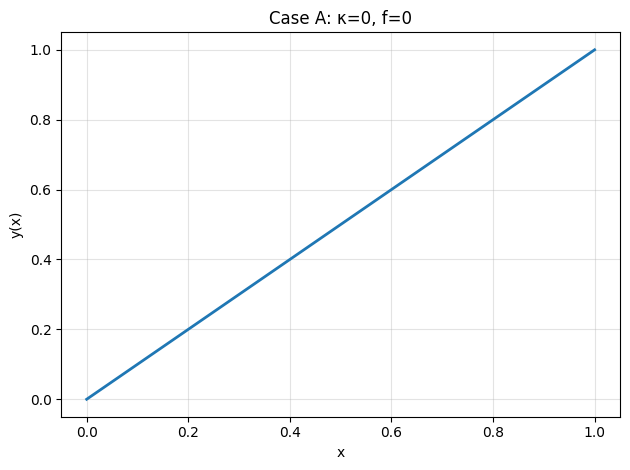

Case A: cycles=1, final relres=5.53e-10


In [ ]:
# 4. Application to Heat Diffusion

# k. Heat Diffusion
Nf = 2**12

levels_A = build_levels(
    Nf=Nf, kappa=0.0, alpha=0.0, beta=1.0,
    f_func=lambda x: np.zeros_like(x)
)
x_A, hist_A = mg_solve(levels_A, m=1, cycle='V', tol=1e-6, max_cycles=1000)
yA = np.empty(x_A.size + 2); yA[0]=0.0; yA[1:-1]=x_A; yA[-1]=1.0
xnodes = np.linspace(0.0, 1.0, yA.size)

plt.figure()
plt.plot(xnodes, yA, lw=2)
plt.title("Case A: κ=0, f=0")
plt.xlabel("x"); plt.ylabel("y(x)"); plt.grid(True, alpha=0.35)
plt.tight_layout(); plt.show()
print(f"Case A: cycles={int(np.sum(np.array(hist_A) > 1e-6))}, final relres={hist_A[-1]:.2e}")


[CHECK] P count OK: 11 = k.


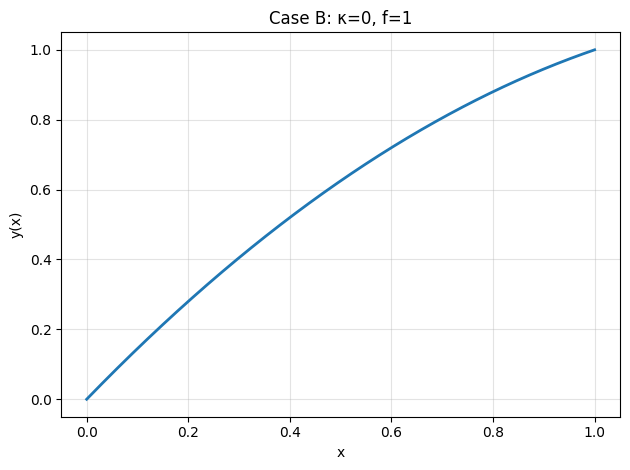

Case B: cycles=1000, final relres=3.77e-06


In [18]:
levels_B = build_levels(
    Nf=Nf, kappa=0.0, alpha=0.0, beta=1.0,
    f_func=lambda x: np.ones_like(x)
)
x_B, hist_B = mg_solve(levels_B, m=1, cycle='V', tol=1e-6, max_cycles=1000)
yB = np.empty(x_B.size + 2); yB[0]=0.0; yB[1:-1]=x_B; yB[-1]=1.0

plt.figure()
plt.plot(xnodes, yB, lw=2)
plt.title("Case B: κ=0, f=1")
plt.xlabel("x"); plt.ylabel("y(x)"); plt.grid(True, alpha=0.35)
plt.tight_layout(); plt.show()
print(f"Case B: cycles={int(np.sum(np.array(hist_B) > 1e-6))}, final relres={hist_B[-1]:.2e}")

[CHECK] P count OK: 11 = k.


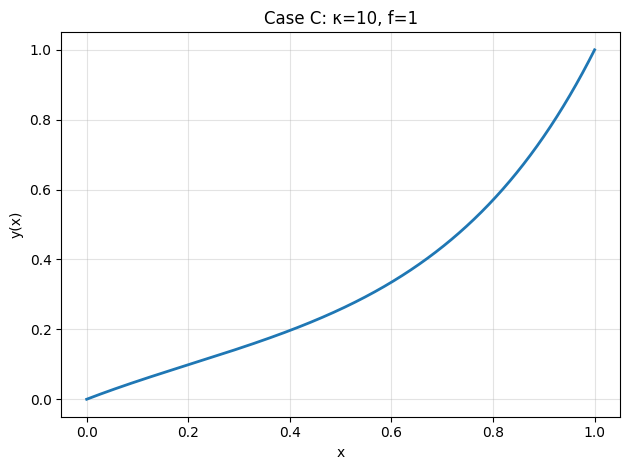

Case C: cycles=1000, final relres=1.28e-05


In [19]:
levels_C = build_levels(
    Nf=Nf, kappa=10.0, alpha=0.0, beta=1.0,
    f_func=lambda x: np.ones_like(x)
)
x_C, hist_C = mg_solve(levels_C, m=1, cycle='V', tol=1e-6, max_cycles=1000)
yC = np.empty(x_C.size + 2); yC[0]=0.0; yC[1:-1]=x_C; yC[-1]=1.0

plt.figure()
plt.plot(xnodes, yC, lw=2)
plt.title("Case C: κ=10, f=1")
plt.xlabel("x"); plt.ylabel("y(x)"); plt.grid(True, alpha=0.35)
plt.tight_layout(); plt.show()
print(f"Case C: cycles={int(np.sum(np.array(hist_C) > 1e-6))}, final relres={hist_C[-1]:.2e}")
